## Import all the libraries we need
## Version - Python v3 used in Jupyter v6.0.3
### Libraries used:
### 'catboost' for model training, lasio,os,numpy,pandas, matplotlib, math, seaborn, sklearn.model_selection, sklearn.metrics, scipy, xlsxwriter and xlrd

In [2]:
import lasio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xg
from catboost import CatBoost
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from scipy import stats

Import all las files into las objects at once. This will save us time because the read method of lasio is much slower than just calling an already imported las object.

In [3]:
lasDic = {}
for filename in os.listdir("C:\\Users\\paras\\Documents\\WellLogging_Datathon\\ML Challenge Data"):
    if filename.endswith(".las"):
        lasDic[filename] = lasio.read("C:\\Users\\paras\\Documents\\WellLogging_Datathon\\ML Challenge Data\\"+filename)

In [4]:
#check file versions
for filename in lasDic:
    las = lasDic[filename]
    print(las.version)

Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------

In [5]:
#Extract well locations
#NOTE: well locations are offset by a constant latitude/longitude to make them non-traceable
#however, their relative distance is preserved.

Lat = []
Lon = []
for filename in lasDic:
    las = lasDic[filename]
    Lat.append(las.well['SLAT'].value)
    Lon.append(las.well['SLON'].value)

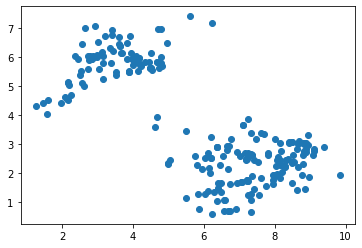

In [6]:
plt.scatter(Lon,Lat)
plt.show()

In [7]:
for filename in lasDic:
    las = lasDic[filename]
    for curve in las.curves:
        if curve.mnemonic == 'LLD':
            print(las.curves)

Mnemonic  Unit  Value  Description                                                            
--------  ----  -----  -----------                                                            
DEPT      FT           DEPTH FEET                                                             
CALD      IN           CALIPER FROM CNL-LDT LOG                                               
CALS      IN           CALIPER FROM BCS-DAS LOG                                               
CILD      MMHO         CONDUCTIVITY FROM DIL-PI-SFL-DLL-MSFL LOG                              
DPHI_LS   DEC          DENSITY POROSITY LIMESTONE [M=2.71,F=1.0] FROM CNL-LDT LOG             
DRHO      G/C3         DENSITY CORRECTION FROM CNL-LDT LOG                                    
DT        US/F         DELTA TIME FROM BCS-DAS LOG                                            
DTCO      US/F         DELTA TIME COMPRESSIONAL FROM BCS-DAS LOG                              
DTSM      US/F         DELTA TIME SHEAR WAVE FROM 

#### Count the times each mnemonic appears in the set of all files.

In [8]:
curveCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[0] in curveCount.keys():
            curveCount[item[0]] += 1
        else:
            curveCount[item[0]] = 1

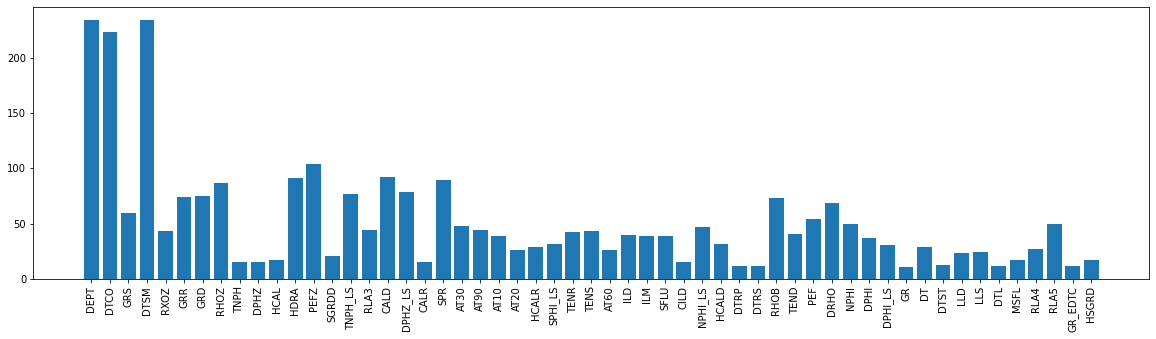

In [9]:
keys = [] #list of mnemonics
for key in curveCount:
    if curveCount[key] > 10:
        keys.append(key)
values = [curveCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

#### Instead of counting the number of times a given mnemonic appears in the entire wells dataset, we can count how many times a given unit of measurement (which is associated with a mnemonic appears). This may be useful because several mnemonics can have the same units and can possibly represent the same physical measure.

In [10]:
unitCount = {} # a dictionary of units as keys and no. of times a unit appears in all log files as values
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[1].unit in unitCount.keys():
            unitCount[item[1].unit] += 1
        else:
            unitCount[item[1].unit] = 1

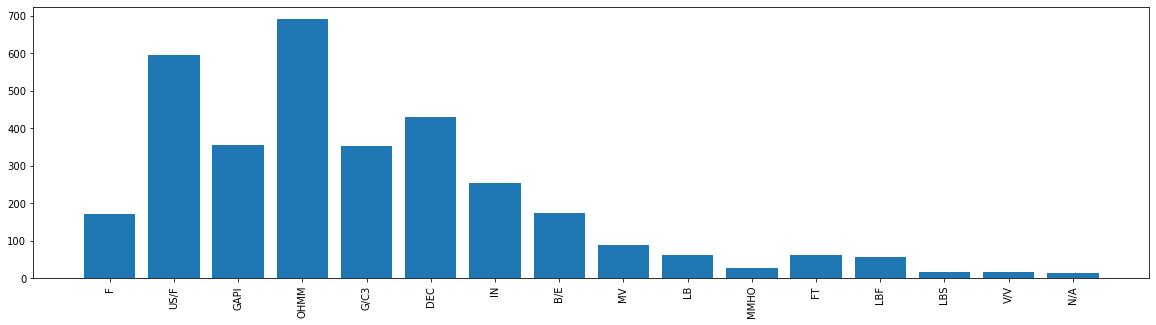

In [11]:
keys = [] #list of all units
for key in unitCount:
    if unitCount[key] > 10: #checking count of each unit > 10
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

#### Alternatively, we can count how many times a unit appears in the whole dataset but counting it for every well only once.

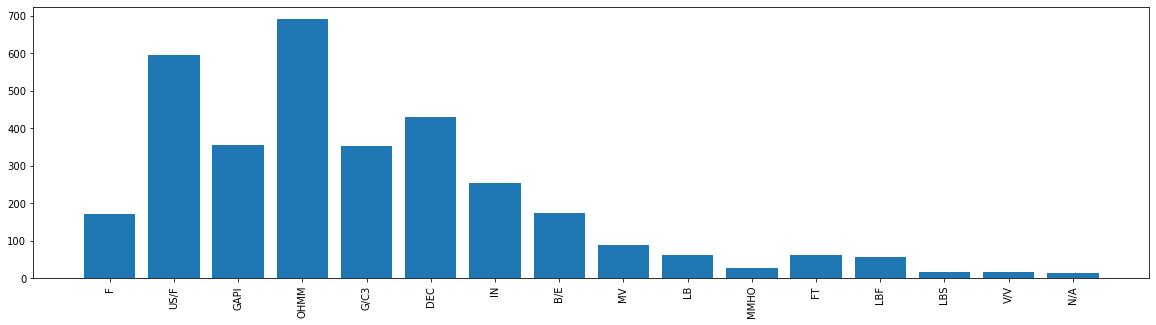

In [12]:
keys = []
for key in unitCount:
    if unitCount[key] > 10:
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

In [13]:
keys

['F',
 'US/F',
 'GAPI',
 'OHMM',
 'G/C3',
 'DEC',
 'IN',
 'B/E',
 'MV',
 'LB',
 'MMHO',
 'FT',
 'LBF',
 'LBS',
 'V/V',
 'N/A']

In [14]:
m_dic = {} # a dictionary of units as keys and list of mnemonics as values
for filename in lasDic:
    las = lasDic[filename] #lasio object
    for item in las.curves.iteritems():
        if item[1].unit in keys:
            if item[1].unit in m_dic.keys():
                q = item[1].mnemonic + " : " + item[1].descr
                m_dic[item[1].unit].add(q)
            else:
                q = item[1].mnemonic + " : " + item[1].descr
                m_dic[item[1].unit] = set(q)

In [15]:
m_dic['DEC']

{' ',
 ':',
 'A',
 'APLC_LS : APS NEAR/ARRAY CORRECTED LIMESTONE POROSITY',
 'APLC_LS : APS NEAR/ARRAY CORRECTED LIMESTONE POROSITY FROM APLC LOG',
 'CNC : NEUTRON POROSITY LIMESTONE',
 'CNC_LS : BOREHOLE SIZE CORRECTED COMPENSATED NEUTRON POROSITY (LIMESTONE)',
 'CNPOR_LS : COMPENSATED ENHANCED THERMAL NEUTRON POROSITY IN SELECTED LITHOLOGY LIMESTONE',
 'CNPOR_LS : COMPENSATED ENHANCED THERMAL NEUTRON POROSITY IN SELECTED LITHOLOGY LIMESTONE FROM CNL LOG',
 'DPHI : DENSITY POROSITY',
 'DPHI : DENSITY POROSITY LIMESTONE',
 'DPHI : DENSITY POROSITY SANDSTONE',
 'DPHI_LS : DENSITY POROSITY LIMESTONE',
 'DPHI_LS : DENSITY POROSITY LIMESTONE [M=2.71, F=1.1] FROM SDL-DSN LOG',
 'DPHI_LS : DENSITY POROSITY LIMESTONE [M=2.71,F=1.0] FROM CNL-LDT LOG',
 'DPHI_SLDT : DENSITY POROSITY LIMESTONE',
 'DPHZ : DENSITY POROSITY LIMESTONE',
 'DPHZ : HRGD STANDARD RESOLUTION DENSITY POROSITY',
 'DPHZ2 : HRGD STANDARD RESOLUTION DENSITY POROSITY',
 'DPHZ_LS : DENSITY POROSITY LIMESTONE [M=2.71, F=1.1] FRO

#### We can map out how two particular mnmonics appears across all wells and across all depths. For example, we can select GRD and GRS and look to see at which wells and at what depth intervals, one of them, both of them, or none of them appear.

In [16]:
maxdepth = 25000
datamap = np.ndarray(shape=(maxdepth, len(lasDic)), dtype=int)
x1 = 'GRD'
x2 = 'GRR'
wellNo = 0
for filename in lasDic:
    print("on well: {}".format(filename))
    df = lasDic[filename].df()
    allmeasures = list(df.columns)
    for i in range(maxdepth):
        if i not in df.index:
            datamap[i,wellNo] = 0 #code for no data at all at that depth
            continue
        try:
            x1_val = df.loc[i, x1]
        except:
            x1_val = np.nan
        try:
            x2_val = df.loc[i, x2]
        except:
            x2_val = np.nan
            
        if np.isnan(x1_val) and np.isnan(x2_val):
            datamap[i,wellNo] = 1 #code for data available at the depth but not x1 or x2
        elif not np.isnan(x1_val) and  np.isnan(x2_val):
            datamap[i,wellNo] = 2 #code for only x1 available at that depth
        elif np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 3 #code for only x2 available at that depth
        elif not np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 4 #code for both x1 and x2 available at that depth
    wellNo += 1
            

on well: 0052442d0162_TGS.las
on well: 00a60e5cc262_TGS.las
on well: 01c726e0fabe_TGS.las
on well: 02571837c35f_TGS.las
on well: 03d4fc789db8_TGS.las
on well: 046bc790f386_TGS.las
on well: 0542bc36f0cb_TGS.las
on well: 069d09bef946_TGS.las
on well: 07bda346ac4d_TGS.las
on well: 095b70877102_TGS.las
on well: 09a9e11b83f4_TGS.las
on well: 0a65a72dd23f_TGS.las
on well: 0df16b6a5cc4_TGS.las
on well: 0e121cce5c23_TGS.las
on well: 0f3ce2a7dd98_TGS.las
on well: 0f7a4609731a_TGS.las
on well: 113ec23e6142_TGS.las
on well: 115b34035794_TGS.las
on well: 11e86c424d08_TGS.las
on well: 1332e8ac4af0_TGS.las
on well: 146b023afbcf_TGS.las
on well: 15560bf61021_TGS.las
on well: 16bb5ea9d2d3_TGS.las
on well: 1737d6c90d5e_TGS.las
on well: 19ed10214869_TGS.las
on well: 1a000e7f474b_TGS.las
on well: 1ad2434c11e7_TGS.las
on well: 1bff6afa48e2_TGS.las
on well: 1cf78b7ca1cc_TGS.las
on well: 1dab7ce73d3f_TGS.las
on well: 1f439d39052a_TGS.las
on well: 1f854180654f_TGS.las
on well: 1f901b2ab8a5_TGS.las
on well: 2

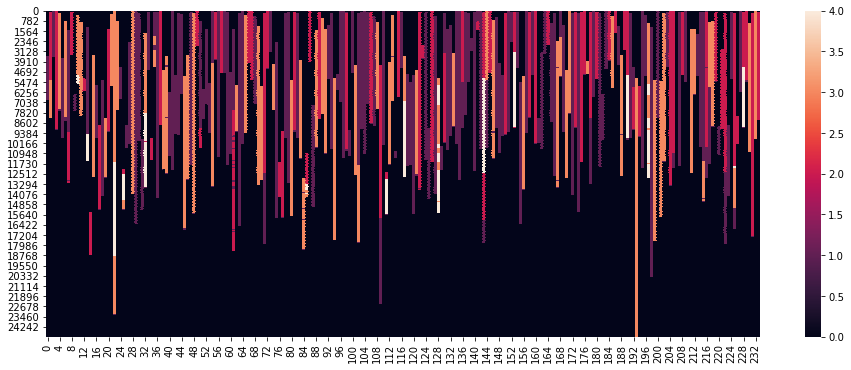

In [17]:
plt.figure(figsize=(16,6))
ax=sns.heatmap(datamap)

#### Here, we will go through all rows of all wells data and extract those that have both "GRD" and "GRS" listed for the same depth.

In [18]:
x1 = 'GRD'
x2 = 'GRS'
x1List = []
x2List = []
file_count = 0
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if x1 in allmeasures and x2 in allmeasures:
        file_count += 1;
        for index, row in lasDic[filename].df().iterrows():
            x1_val = row[allmeasures.index(x1)]
            x2_val = row[allmeasures.index(x2)]
            if not isnan(x1_val) and not isnan(x2_val):
                x1List.append(x1_val)
                x2List.append(x2_val)
print(file_count)

21


In [19]:
#Filecount
x1 = 'LLD'
x2 = 'ILD'
x1List = []
x2List = []
file_count = 0
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if x1 in allmeasures and x2 in allmeasures:
        file_count += 1;
print(file_count)

4


In [20]:
#Counting number of files for list of curves
c=0
for filename in lasDic:
    las = lasDic[filename]
    mnemoniclist = [curve.mnemonic for curve in las.curves]
    #for curve in las.curves:
        #if ['AT10','AT20','AT30','AT60','AT90'] in mnemoniclist:
    if all([item in mnemoniclist for item in ['PEF','PEFZ']]):
        c+=1
        #print(filename,las.curves)    
c

3

#### Here we extract the actual log data from the las file.

(93.1397, 235.2891)

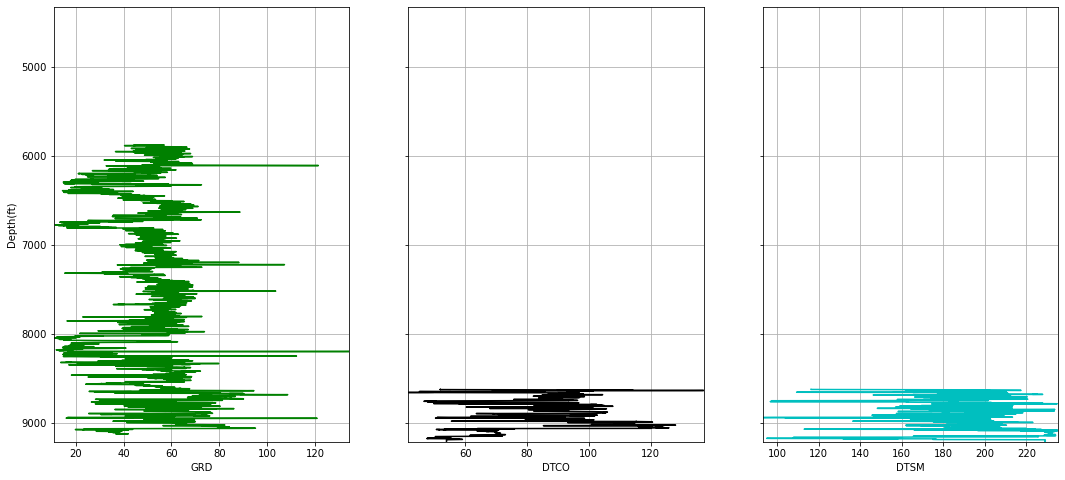

In [21]:
las = lasDic['cbe115c74a89_TGS.las']
logs = las.df()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), sharey=True)
ax[0].plot(logs.GRD, logs.index, color='green')
ax[1].plot(logs.DTCO, logs.index, color='black')
ax[2].plot(logs.DTSM, logs.index, color='c')
for i in range(len(ax)):
    ax[i].set_ylim(logs.index[0], logs.index[-1])
    ax[i].invert_yaxis()
    ax[i].grid()

ax[0].set_xlabel("GRD")
ax[0].set_xlim(logs.GRD.min(), logs.GRD.max())
ax[0].set_ylabel("Depth(ft)")
ax[1].set_xlabel("DTCO")
ax[1].set_xlim(logs.DTCO.min(), logs.DTCO.max())
ax[2].set_xlabel("DTSM")
ax[2].set_xlim(logs.DTSM.min(), logs.DTSM.max())

#### Let's gather x and y data with x being a set of mnemonics that are pretty frequently occured and y as the parameter of interest and train this with a catboost regressor.
#### Some useful functions to cut down code repeatation time

In [22]:
def gr_mnemonic(lasdf):
    allmeasures = list(lasdf.columns)
    if 'GRD' in allmeasures and 'GRS' not in allmeasures and 'GRR' not in allmeasures:
        lasdf=lasdf.rename(columns={"GRD":"GRS"})
    if 'GRR' in allmeasures and 'GRS' not in allmeasures and 'GRD' not in allmeasures:
        lasdf=lasdf.rename(columns={"GRR":"GRS"})
    if 'GRR' in allmeasures and 'GRD' in allmeasures:
        lasdf=lasdf.rename(columns={"GRR":"GRS"})
    return lasdf

def den_neu_pe_mnemonic(lasdf):
    allmeasures = list(lasdf.columns)
    if 'RHOZ' in allmeasures:
        lasdf=lasdf.rename(columns={"RHOZ":"RHOB"})
    if 'NPHI_LS' in allmeasures and 'NPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"NPHI_LS":"NPHI"})
    if 'DPHI_LS' in allmeasures and 'DPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPHI_LS":"DPHI"})
    if 'DPHZ_LS' in allmeasures and 'DPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPHZ_LS":"DPHI"})
    if 'DPO_LS' in allmeasures and 'DPHI' not in allmeasures and 'DPHZ_LS' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPO_LS":"DPHI"})
    if 'PEF' in allmeasures and 'PEFZ' not in allmeasures:
        lasdf=lasdf.rename(columns={"PEF":"PEFZ"})
    #if 'SPHI_LS' in allmeasures and 'DPHI' not in allmeasures:
    #    lasdf=lasdf.rename(columns={"SPHI_LS":"DPHI"})
    return lasdf

def res_mnemonic(lasdf):
    allmeasures = list(lasdf.columns)
    #if 'ILD' in allmeasures and 'LLD' not in allmeasures:
    #    lasdf=lasdf.rename(columns={"ILD":"LLD"})
    #if 'ILD' in allmeasures and 'LLD' in allmeasures:
    #    lasdf=lasdf.drop('LLD',1)
    #    lasdf=lasdf.rename(columns={"ILD":"LLD"})    
    #if 'ILM' in allmeasures and 'LLM' not in allmeasures:
    #    lasdf=lasdf.rename(columns={"ILM":"LLM"})
    if 'SFLU' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"SFLU":"MSFL"})
    if 'SFL' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"SFL":"MSFL"})
    if 'AT90' in allmeasures and 'LLD' not in allmeasures:
        lasdf=lasdf.rename(columns={"AT90":"LLD"})    
    if 'AT30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AT30":"LLM"})
    if 'AT10' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"AT10":"MSFL"})
    if 'AF10' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"AF10":"MSFL"})
    if 'AHT10' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"AHT10":"MSFL"})
    if 'AST10' in allmeasures and 'MSFL' not in allmeasures:
        lasdf=lasdf.rename(columns={"AST10":"MSFL"})
    return lasdf

def pef_menmonic(lasdf):
    allmeasures = list(lasdf.columns)
    if 'PEFZ' in allmeasures and 'PEF' not in allmeasures:
        lasdf=lasdf.rename(columns={"PEFZ":"PEF"})
    if 'PE' in allmeasures and 'PEF' not in allmeasures:
        lasdf=lasdf.rename(columns={"PE":"PEF"})
    return lasdf

def dn_porosity(lasdf):
    d = np.square(lasdf['DPHI'].to_numpy())
    n = np.square(lasdf['NPHI'].to_numpy())
    dn = (np.power((d + n)/2,0.5)).reshape(-1,1)
    lasdf['DN_PHI'] = dn
    return lasdf

In [10]:
#ild_mnemonic

def llm_mnemonic(lasdf):
    allmeasures = list(lasdf.columns)
    if 'ILM' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"ILM":"LLM"})  
    if 'AT30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AT30":"LLM"})  
    if 'AF30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AF30":"LLM"})  
    if 'AHT30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AHT30":"LLM"})  
    if 'AST30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AST30":"LLM"})  
    if 'AO30' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"AO30":"LLM"})  
    if 'IMPH' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"IMPH":"LLM"})  
    if 'IMBC' in allmeasures and 'LLM' not in allmeasures:
        lasdf=lasdf.rename(columns={"IMBC":"LLM"})
    return lasdf

In [8]:
def removenacol_gr(d):
    s = d.notna().sum()
    mnemoniclist = list(d.columns.values)
    #GRS,GRR,GRD
    if all([item in mnemoniclist for item in ['GRR','GRD','GRS']]):
            if s['GRR'] > s['GRD'] and  s['GRR'] > s['GRS']:
                d = d.drop(['GRD','GRS'],axis=1)

            elif s['GRD'] > s['GRR'] and  s['GRD'] > s['GRS']:
                d = d.drop(['GRR','GRS'],axis=1)
            else:
                d = d.drop(['GRR','GRD'],axis=1)
            return d
    #GRR,GRD
    if all([item in mnemoniclist for item in ['GRR','GRD']]):
            if s['GRR'] > s['GRD']:
                d = d.drop(['GRD'],axis=1)
            else:
                d = d.drop(['GRR'],axis=1)
            return d
    #GRS,GRD
    if all([item in mnemoniclist for item in ['GRS','GRD']]):
            if s['GRS'] > s['GRD']:
                d = d.drop(['GRD'],axis=1)
            else:
                d = d.drop(['GRS'],axis=1)
            return d
    #GRR,GRS
    if all([item in mnemoniclist for item in ['GRR','GRS']]):
            if s['GRR'] > s['GRS']:
                d = d.drop(['GRS'],axis=1)
            else:
                d = d.drop(['GRR'],axis=1)
            return d
    #GRS,GRD
    if all([item in mnemoniclist for item in ['GRS','GRD']]):
            if s['GRS'] > s['GRD']:
                d = d.drop(['GRD'],axis=1)
            else:
                d = d.drop(['GRS'],axis=1)
            return d
    return d

def removenacol_rhob(d):
    s = d.notna().sum()
    mnemoniclist = list(d.columns.values)
    #RHOB,RHOZ
    if all([item in mnemoniclist for item in ['RHOB','RHOZ']]):
            if s['RHOB'] > s['RHOZ']:
                d = d.drop(['RHOZ'],axis=1)
            else:
                d = d.drop(['RHOB'],axis=1)
            return d
    return d
    
def removenacol(d):
    s = d.notna().sum()
    mnemoniclist = list(d.columns.values)
    for colname, val in s.iteritems():
        if val == 0:
            d = d.drop(colname,axis = 1)
    return d
    
def removenacol_pef(d):
    s = d.notna().sum()
    mnemoniclist = list(d.columns.values)
    #PEF,PEFZ
    if all([item in mnemoniclist for item in ['PEF','PEFZ']]):
            if s['PEF'] > s['PEFZ']:
                d = d.drop(['PEFZ'],axis=1)
            else:
                d = d.drop(['PEF'],axis=1)
            return d
    if all([item in mnemoniclist for item in ['PE','PEFZ']]):
            if s['PE'] > s['PEFZ']:
                d = d.drop(['PEFZ'],axis=1)
            else:
                d = d.drop(['PE'],axis=1)
            return d
    if all([item in mnemoniclist for item in ['PE','PEF']]):
            if s['PE'] > s['PEF']:
                d = d.drop(['PEF'],axis=1)
            else:
                d = d.drop(['PE'],axis=1)
            return d
    return d

## Function to prepare training dataframe

In [23]:
def xytrain(lasDic,xlabels,ylabels):
    x = []
    y = []
    logs_used = 0
    for filename in lasDic:
        lasdf = lasDic[filename].df()
        lasdf['DEPT'] = lasdf.index
        lasdf['LON'] = lasDic[filename].well['SLON'].value
        lasdf['LAT'] = lasDic[filename].well['SLAT'].value
        lasdf = removenacol(lasdf)
        lasdf = removenacol_gr(lasdf)
        lasdf = removenacol_rhob(lasdf)
        lasdf = removenacol_pef(lasdf)

        allmeasures = list(lasdf.columns)
        lasdf = gr_mnemonic(lasdf)
        lasdf = den_neu_pe_mnemonic(lasdf)
        lasdf = res_mnemonic(lasdf)
        lasdf = pef_menmonic(lasdf)

        allmeasures = list(lasdf.columns)
        if all([item in allmeasures for item in xlabels+ylabels]):
            lasdf = lasdf[lasdf['DTSM']/lasdf['DTCO'] < 4.6]
            logs_used += 1
            for index, row in lasdf.iterrows():
                inputs = []
                [inputs.append(row[allmeasures.index(i)]) for i in xlabels]
                outputs = []
                [outputs.append(row[allmeasures.index(i)]) for i in ylabels]
                if all([not isnan(item) for item in inputs+outputs]):
                    x.append(inputs)
                    y.append(outputs)
    x = np.asarray(x)
    y = np.asarray(y)
    check_dec = True
    X_df = pd.DataFrame({'DEPT': x[:, 0], 'GRS': x[:, 1], 'DTCO':x[:,2], 'RHOB':x[:,3], 'DPHI':x[:,4], 'NPHI':x[:,5],'LON':x[:,6],'LAT':x[:,7]})
    
    y = pd.DataFrame(y)
    y.columns = ['DTSM']
    X_df = dn_porosity(X_df)
    X_df = X_df.drop(['DPHI','NPHI'],axis=1)
    return X_df, y

In [24]:
# Labels to be used for training
xlabels = ['DEPT','GRS', 'DTCO','RHOB','DPHI','NPHI','LON','LAT']
ylabels = ['DTSM']

# Training dataframes
X_df, y = xytrain(lasDic,xlabels,ylabels)
print(X_df.head())
print(y.head())

63
     DEPT       GRS     DTCO    RHOB       LON       LAT    DN_PHI
0  6496.0  113.3206  78.3858  2.6722  3.680102  6.169119  0.179726
1  6496.5  115.1263  78.3858  2.6769  3.680102  6.169119  0.176225
2  6497.0  116.4574  78.3858  2.6778  3.680102  6.169119  0.174464
3  6497.5  117.1965  78.3858  2.6756  3.680102  6.169119  0.173479
4  6498.0  113.8235  78.3858  2.6686  3.680102  6.169119  0.172659
       DTSM
0  145.3150
1  145.3150
2  145.3150
3  145.7087
4  145.7087


In [25]:
X_df.describe()

# Also calcuated cross plot porosity from density and neutron porosity values for logs where available

,DEPT,GRS,DTCO,RHOB,LON,LAT,DN_PHI
count,290590.000000,290590.000000,290590.000000,290590.00000,290590.000000,290590.000000,290590.000000
mean,8894.145718,76.202089,68.128344,2.58596,4.712082,4.679981,0.131615
std,3906.820389,41.719000,16.290134,0.15743,1.573713,1.818549,0.079129
min,678.000000,1.151500,33.895000,1.05780,1.468371,0.701459,0.000071
25%,5851.500000,42.133100,56.877825,2.52160,3.878737,2.814888,0.070474
50%,8973.000000,77.891350,66.598400,2.61410,4.471880,5.564676,0.124493
75%,11719.474975,105.566950,76.838500,2.67020,6.369238,5.836093,0.181182
max,20670.000000,623.161700,353.983300,4.01730,8.877750,7.421619,0.854405


## Function 'xytrain()' can be modified to include training dataframe for various mneumonics required for each well based on the mneumonics present in it. It was done, however, and than the organizing team wanted to only one model with one prediction, so I had to changed the number of models to one as shown above in code. But the prediction was still good.  

##### Labels to be used for training without density and neutron curves
xlabels = ['DEPT','GRS', 'DTCO','RHOB','LON','LAT']
ylabels = ['DTSM']

##### Training dataframes
X_df, y = xytrain(lasDic,xlabels,ylabels)
print(X_df.head())
print(y.head())

##### Labels to be used for training with MSFL curve
xlabels = ['DEPT','GRS', 'DTCO','DPHI','NPHI','MSFL','RHOB','LON','LAT']
ylabels = ['DTSM']

##### Training dataframes
X_df, y = xytrain(lasDic,xlabels,ylabels)
print(X_df.head())
print(y.head())

##### Labels to be used for training with ILM curve
xlabels = ['DEPT','GRS', 'DTCO','DPHI','NPHI','ILM','RHOB','LON','LAT']
ylabels = ['DTSM']

##### Training dataframes
X_df, y = xytrain(lasDic,xlabels,ylabels)
print(X_df.head())
print(y.head())

# CAT Boost Regressor algorithm

In [ ]:
#Grid search cv

train_data = X_df
train_labels = y

modelr = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = modelr.grid_search(grid,X=x,y=y, plot=True)

In [ ]:
grid_search_result['params']

## Function to train a model

In [16]:
def traincatmodel(X_df,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.35, random_state=1)

    # initialize Pool
    train_pool = Pool(X_train,y_train)
    test_pool = Pool(X_test) 

    eval_dataset = Pool(X_test, y_test)

    #Parameters for the model
    params = {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
    params['iterations'] = 10000
    params['loss_function']='RMSE'
    params['eval_metric']='RMSE'
    #params['task_type'] = 'GPU'

    # specify the training parameters 
    model = CatBoost(params)

    #train the model
    #model.fit(train_pool,eval_set=eval_dataset,verbose=False)
    
    try:
        model.fit(train_pool,use_best_model=True,eval_set=eval_dataset,verbose=False)
        print(model.get_best_score())
        print(model.get_best_iteration())
    except:
        print('Model training error')
        return None
    
    #preds = model.predict(test_pool)
    #rmse = np.sqrt(MSE(y_test,preds))
    #print(model.get_feature_importance(prettified = True))
    return model

# Model to be used

## Model was trained with near, far and shallow resistivity curves and near resistivity curve i.e. MSFL or SFLU gave the lowest RMSE

In [26]:
model = traincatmodel(X_df,y)

{'learn': {'RMSE': 2.5691533565427296}, 'validation': {'RMSE': 6.91415024635065}}
9998


#### Code to save model to a file:

model.save_model("m1")

# Test Wells prediction 

In [19]:
#Test Wells prediction
#use model 

lasDic_test = {}
for filename in os.listdir("C:\\Users\\paras\\Documents\\WellLogging_Datathon\\Testwell_final\\"):
    if filename.endswith(".las"):
        lasDic_test[filename] = lasio.read("C:\\Users\\paras\\Documents\\WellLogging_Datathon\\Testwell_final\\"+filename)

In [20]:
Latt = []
Lont = []
for filename in lasDic_test:
    las = lasDic_test[filename]
    Latt.append(las.well['SLAT'].value)
    Lont.append(las.well['SLON'].value)

In [21]:
for filename in lasDic_test:
    las = lasDic_test[filename]
    print(las.curves)

Mnemonic  Unit  Value  Description                                               
--------  ----  -----  -----------                                               
DEPT      F            1 MEASURED DEPTH                                          
DPHI_LS   DEC          DENSITY POROSITY LIMESTONE                                
NPHI_LS   DEC          NEUTRON POROSITY LIMESTONE                                
DRHO      G/C3         BULK DENSITY CORRECTION                                   
PEF       B/E          PHOTOELECTRIC FACTOR                                      
CALD      IN           CALIPER FROM DENSITY LOG                                  
RHOB      G/C3         BULK DENSITY                                              
GRR       GAPI         GAMMA RAY FROM RESISTIVITY LOG                            
ILD       OHMM         INDUCTION DEEP RESISTIVITY                                
ILM       OHMM         INDUCTION MEDIUM RESISTIVITY                              
SPR       MV    

In [22]:
def den_neu_mnemonict(lasdf):
    allmeasures = list(lasdf.columns)
    if 'RHOZ' in allmeasures and 'RHOB' not in allmeasures:
        lasdf=lasdf.rename(columns={"RHOZ":"RHOB"})
    if 'RHOM' in allmeasures and 'RHOB' not in allmeasures:
        lasdf=lasdf.rename(columns={"RHOM":"RHOB"})
    if 'NPHI_LS' in allmeasures and 'NPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"NPHI_LS":"NPHI"})
    if 'NPOR_LS' in allmeasures and 'NPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"NPOR_LS":"NPHI"})
    if 'DPHI_LS' in allmeasures and 'DPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPHI_LS":"DPHI"})
    if 'DPHZ_LS' in allmeasures and 'DPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPHZ_LS":"DPHI"})
    if 'DPHZ' in allmeasures and 'DPHI' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPHZ":"DPHI"})
    if 'DPO_LS' in allmeasures and 'DPHI' not in allmeasures and 'DPHZ_LS' not in allmeasures:
        lasdf=lasdf.rename(columns={"DPO_LS":"DPHI"})
    return lasdf

def llm_mnemonict(lasdf):
    allmeasures = list(lasdf.columns)
    if 'MSFL' not in allmeasures and 'IMPH' in allmeasures:
        lasdf=lasdf.rename(columns={"IMPH":"LLM"})
    if 'MSFL' not in allmeasures and 'ILM' in allmeasures:
        lasdf=lasdf.rename(columns={"ILM":"LLM"})
    return lasdf



m1_withmsfl = CatBoost()

m1_withmsfl.load_model("m1_withmsfl")


In [46]:
xlabels = ['DEPT','GRS', 'DTCO','RHOB','LON','LAT','DN_PHI']
ylabels = ['DTSM']
logs_usedt = 0
j=1
dtsm_pred = {}
dtco_c = {}
dept_pred = {}
files_remaining = []
#print("PREDICTION MADE FOR:")
for filename in lasDic_test:
    xt = []
    lasdft = lasDic_test[filename].df()    
    lasdft['DEPT'] = lasdft.index
    lasdft['LON'] = lasDic_test[filename].well['SLON'].value
    lasdft['LAT'] = lasDic_test[filename].well['SLAT'].value
        
    lasdft = removenacol(lasdft)
    lasdft = removenacol_gr(lasdft)
    lasdft = removenacol_rhob(lasdft)
    
    lasdft = gr_mnemonic(lasdft)
    lasdft = den_neu_mnemonict(lasdft)
    lasdft = res_mnemonic(lasdft)
    #lasdft = llm_mnemonic(lasdft)
    allmeasures = list(lasdft.columns)
    
    if 'DPHI' not in allmeasures or 'NPHI' in allmeasures:
        lasdft=lasdft.rename(columns={"NPHI":"DN_PHI"})
        check = True
    elif 'DPHI' in allmeasures or 'NPHI' not in allmeasures:
        lasdft=lasdft.rename(columns={"DPHI":"DN_PHI"})
        check = True
    elif 'DPHI' in allmeasures or 'NPHI' in allmeasures:
        lasdft = dn_porosity(lasdft)
        lasdft = lasdft.drop(['DPHI','NPHI'],axis=1)
        check = True
    else:
        check = False
    
    logs_usedt += 1
    allmeasures = list(lasdft.columns)
    if check == True:
        for index, row in lasdft.iterrows():
            inputs = []
            for i in xlabels:
                try:
                    inputs.append(row[allmeasures.index(i)])
                except:
                    inputs.append(np.nan)
            xt.append(inputs)
        xt = np.asarray(xt)
        xtt = pd.DataFrame({'DEPT': xt[:, 0], 'GRS': xt[:, 1], 'DTCO':xt[:,2], 'RHOB':xt[:,3], 'LON':xt[:,4],'LAT':xt[:,5],'DN_PHI':xt[:,6]})
        #xtt = scaler.fit_transform(xtt)
        #print(xtt.shape)
        #prediction using catboost model
        t_pool = Pool(xtt)
        dtsm_pred[filename] = m1_withmsfl.predict(t_pool)
        dtco_c[filename] = xtt['DTCO']
        dept_pred[filename] = lasdft['DEPT']
        j+=1
    else:
        files_remaining.append(filename)    
        print(j)
        j+=1
    
#yt = np.asarray(yt)
print(logs_usedt)

20


In [47]:
print("Files remaining")
for file in files_remaining:
    ldf=lasDic_test[file].df()
    print(file," : ", ldf.columns.values)

Files remaining


In [35]:
for k,w in dtco_c.items():
    print(w.dropna())

268     94.7319
269     93.9082
270     93.7036
271     93.3917
272     92.2643
         ...   
838    102.4049
839    102.7094
840    102.8968
841    102.9772
842    102.9745
Name: DTCO, Length: 575, dtype: float64
24      58.0070
25      57.8572
26      57.5373
27      57.3853
28      57.4391
         ...   
5130    74.7632
5131    75.1729
5132    75.3172
5133    75.3308
5134    75.3243
Name: DTCO, Length: 5111, dtype: float64
0        82.0401
1        81.7476
2        80.6990
3        79.7359
4        78.7728
          ...   
12839    54.2023
12840    50.3113
12841    47.1984
12842    47.5876
12843    50.6926
Name: DTCO, Length: 12844, dtype: float64
0        71.2017
1        70.2243
2        67.5032
3        60.7898
4        56.5389
          ...   
13250    59.9214
13251    58.4130
13252    56.8803
13253    56.0052
13254    55.3228
Name: DTCO, Length: 13255, dtype: float64
0       124.0252
1       111.5703
2       109.1775
3       108.1797
4       107.2757
          ...   
2142   

In [37]:
for key,dtsmp in dept_pred.items():
    r = pd.DataFrame(dtsmp)
    print(key)
    print(r.info())

00d02be79f49_TGS.las
<class 'pandas.core.frame.DataFrame'>
Float64Index: 1307 entries, 9912.0 to 10565.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPT    1307 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB
None
0a7822c59487_TGS.las
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5135 entries, 5868.0 to 8435.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPT    5135 non-null   float64
dtypes: float64(1)
memory usage: 80.2 KB
None
113412eec2a6_TGS.las
<class 'pandas.core.frame.DataFrame'>
Float64Index: 12846 entries, 5000.0 to 11422.5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPT    12846 non-null  float64
dtypes: float64(1)
memory usage: 200.7 KB
None
1684cc35f399_TGS.las
<class 'pandas.core.frame.DataFrame'>
Float64Index: 13255 entries, 5994.0 to 12621.0
Data column

In [38]:
for key,dtsmp in dtsm_pred.items():
    r = pd.DataFrame(dtsmp)
    print(key)
    print(r.info())

00d02be79f49_TGS.las
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1307 non-null   float64
dtypes: float64(1)
memory usage: 10.3 KB
None
0a7822c59487_TGS.las
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5135 entries, 0 to 5134
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5135 non-null   float64
dtypes: float64(1)
memory usage: 40.2 KB
None
113412eec2a6_TGS.las
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12846 entries, 0 to 12845
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12846 non-null  float64
dtypes: float64(1)
memory usage: 100.5 KB
None
1684cc35f399_TGS.las
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13255 entries, 0 to 13254
Data columns (total 1 columns):
 #   Column  Non

# Exporting data

In [39]:
for key,dtsmp in dtsm_pred.items():
    for k,dept in dept_pred.items():
        if key == k:
            print(dtsmp.shape, " : ", dept.shape)

(1307,)  :  (1307,)
(5135,)  :  (5135,)
(12846,)  :  (12846,)
(13255,)  :  (13255,)
(2147,)  :  (2147,)
(3497,)  :  (3497,)
(10745,)  :  (10745,)
(1401,)  :  (1401,)
(2019,)  :  (2019,)
(13883,)  :  (13883,)
(1737,)  :  (1737,)
(1893,)  :  (1893,)
(1291,)  :  (1291,)
(5031,)  :  (5031,)
(16926,)  :  (16926,)
(21678,)  :  (21678,)
(24122,)  :  (24122,)
(3957,)  :  (3957,)
(1465,)  :  (1465,)
(3671,)  :  (3671,)


In [45]:
import xlsxwriter
import xlrd

for key,dtsmp in dtsm_pred.items():
        key = key.split('.')[0]

        # open the file for reading
        wbRD = xlrd.open_workbook('C:/Users/paras/Documents/WellLogging_Datathon/Space troopers_v2/'+key+'.xlsx')
        sheets = wbRD.sheets()

        # open the same file for writing (just don't write yet)
        wb = xlsxwriter.Workbook('C:/Users/paras/Documents/WellLogging_Datathon/Space troopers_v2/'+key+'.xlsx')

        # run through the sheets and store sheets in workbook
        # this still doesn't write to the file yet
        for sheet in sheets: # write data from old file
            newSheet = wb.add_worksheet(sheet.name)
            for row in range(sheet.nrows):
                for col in range(sheet.ncols):
                    newSheet.write(row, col, sheet.cell(row, col).value)

        for row_n, data in enumerate(dtsmp):
            newSheet.write(row_n+1, 1, data)
        wb.close()